In [1]:
import ee
import geemap
import hvplot.pandas
import hvplot.xarray
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import shapely
from sklearn.decomposition import PCA

import constants as c

## 1. Setup GEE API and Map

In [125]:
ee.Authenticate()
ee.Initialize()

## 2. Get MRC Metadata and plot stations

In [ ]:
# import json
# import urllib.request

# def get_mrc_metadata(return_gdf=True, verbose=False):
#     """ Get Metadata from Mekong River Comission Data Portal. """
#     url = r'https://api.mrcmekong.org/api/v1/ts/inventory/timeSeriesList'
#     urllib.request.urlretrieve(url, 'timeSeriesList.json')
    
#     if verbose:
#         print(f'Downloaded time-series metadata from {url} .')
    
#     f = open('timeSeriesList.json')
#     data = json.load(f)
#     df_metadata = pd.DataFrame([])
#     for dataset in data:
#         df_temp = pd.DataFrame([dict(dataset)])
#         df_temp['longitude'] = df_temp['longitude'].astype(float)
#         df_temp['latitude'] = df_temp['latitude'].astype(float)
#         df_metadata = pd.concat([df_temp, df_metadata])
#         f.close()
#     df_metadata = df_metadata.reset_index().drop(columns=['index'])
    
#     if verbose:
#         print(f'Found a total of {df_metadata.shape[0]} time-series datasets from {len(df_metadata.stationCode.unique())} stations of the MRC Data Portal.')
        
#     if return_gdf:
#         gdf_metadata = gpd.GeoDataFrame(
#             df_metadata, geometry=gpd.points_from_xy(df_metadata.longitude, df_metadata.latitude), crs="EPSG:4326"
#         )
#         return(gdf_metadata)
#     else:
#         return(df_metadata)

# Map = geemap.Map(center=(40, -100), zoom=4)
# Map

# gdf_metadata = get_mrc_metadata(return_gdf=True)
# gdf_metadata_sedi = gdf_metadata.loc[gdf_metadata.parameter=='Sediment Concentration']

# # Get DSMP station metadata
# gdf_metadata_dmsp = gdf_metadata_sedi.loc[gdf_metadata_sedi.label.str.contains('DSMP')]
# gdf_stations_dsmp = gdf_metadata_dmsp.groupby('locationIdentifier').first()[['river', 'stationShortName', 'geometry']].set_crs('EPSG:4326')

# # Get Hydromet stations metadata
# gdf_metadata_hydromet = gdf_metadata_sedi.loc[~gdf_metadata_sedi.label.str.contains('DSMP')]
# gdf_stations_hydromet = gdf_metadata_hydromet.groupby('locationIdentifier').first()[['river', 'stationShortName', 'geometry']].set_crs('EPSG:4326')

# # # Add stations
# Map.add_gdf(gdf_stations_dsmp, 'MRC DSMP stations', style={'fillColor': 'blue'})
# Map.add_gdf(gdf_stations_hydromet, 'MRC Hydromet stations', style={'fillColor': 'red'})

In [ ]:
# # load 3S basin
# json_data = 'geometries/geoms.geojson'
# fc_geoms = geemap.geojson_to_ee(json_data)
# roi_geom = fc_geoms.first().geometry()

# # load dams
# df = pd.read_csv('geometries/3SReservoirs.csv')
# gdf_dams = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_xy(df['X'], df['Y']), crs=4326).drop(columns=['X', 'Y']).set_index('id')
# fc_dams = geemap.geopandas_to_ee(gdf_dams)
# Map.add_gdf(gdf_dams, 'Dams', {'color': 'blue'})

In [ ]:
# # Load data from local .csv files (see 01_insitu_preparation.ipynb)
# paths_data_s = list(Path(f'../mrc_webscrapper/outputs/csv/Sediment Concentration/').glob(f'*.csv'))
# paths_data_q = list(Path(f'../mrc_webscrapper/outputs/csv/Discharge/').glob(f'*.csv'))
# paths_data = paths_data_q + paths_data_s
# df_data = pd.DataFrame([])
# for path in paths_data_s:
#     df_temp = pd.read_csv(path, dtype={'station_code':'str'})
#     df_temp['date_utc'] = pd.to_datetime(df_temp['date'])
#     df_temp['med_frq'] = np.median(np.diff(df_temp.date_utc))
#     df_data = pd.concat([df_data, df_temp])

# df_stations = df_data.groupby('station_code').first()
# gdf_stations = gpd.GeoDataFrame(df_stations,
#                  crs={'init': 'epsg:4326'},
#                  geometry=df_stations.apply(lambda row: shapely.geometry.Point((row.lon, row.lat)), axis=1)
#                 )

# # Create geolocated DSMP/Hydromet datasets
# df_data_dsmp = df_data.loc[df_data.identifier.str.contains('DSMP')]
# gdf_data_dsmp = gpd.GeoDataFrame(df_data_dsmp.join(gdf_stations.geometry, on='station_code'))
# df_data_hydromet = df_data.loc[~df_data.identifier.str.contains('DSMP')]
# gdf_data_hydromet = gpd.GeoDataFrame(df_data_hydromet.join(gdf_stations.geometry, on='station_code'))

## 3. Get data

### Define settings

In [149]:
start_date, end_date = '2000-01-01', '2024-07-05' # timespan to extract
cld_filt_thresh = 70 # scene-based cloud filter
cld_buffer, water_buffer = 250, 30 # cloud (grow) and water (erosion) buffer (meters)
watermask = 'index' # type of watermask to apply
sampling_buffer = 100 # sampling buffer (meters) and reducer
gdrive_folder = r'E:\Google Drive\Earth Engine'
output_folder = 'SOSW_SPM_SR_14052024'

In [152]:
%load_ext autoreload
%autoreload 2
import functions_process as funcs_process
import functions_turbidity as funcs_turb
import functions_sampling as funcs_sampling
from tqdm.notebook import tqdm

# prepare insitu data, remove WQMN (surface grab samples)
df = gpd.read_file('input/insitu_data.csv', ignore_geometry=True)
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry']).set_crs('4326')
gdf_data = gpd.GeoDataFrame(df)
gdf_data = gdf_data.loc[~(gdf_data.geometry.is_empty)]
gdf_data = gdf_data.loc[~(gdf_data.source=='WQMN')]

settings = {
    'start_date':       start_date,
    'end_date':         end_date,
    'cld_buffer':       cld_buffer,
    'water_buffer':     water_buffer,
    'cld_filt_thresh':  cld_filt_thresh,
    'watermask':        watermask,
    'harmonize_bnames': True,
    'add_indices':      True,
    'add_ratios':       True
}

# Run one batch task per stations
tasks = []
for station_id in tqdm(gdf_data.station_id.unique()):
    fn = station_id
    gdf_data_station = gdf_data.loc[gdf_data.station_id==station_id]
    fc_station = ee.FeatureCollection(geemap.gdf_to_ee(
        gdf_data_station, 
        date='dt_utc', date_format='YYYY-MM-dd HH:mm:ss'))
    bounds = fc_station.geometry()
    ic_oli = funcs_process.load_sr_imcoll(sensor='oli', bounds=bounds, **settings)
    ic_etm = funcs_process.load_sr_imcoll(sensor='etm', bounds=bounds, **settings)
    ic_msi = funcs_process.load_sr_imcoll(sensor='msi', bounds=bounds, **settings)
    fc_matchups_oli = funcs_sampling.get_matchups(fc_station, ic_oli, max_diff=3)
    fc_matchups_msi = funcs_sampling.get_matchups(fc_station, ic_msi, max_diff=3)
    fc_matchups_etm = funcs_sampling.get_matchups(fc_station, ic_etm, max_diff=3)
    fc_matchups = ee.FeatureCollection([fc_matchups_oli, fc_matchups_msi, fc_matchups_etm]).flatten() \
        .map(funcs_sampling.get_matchup_sample(buffer_dist=sampling_buffer))
    # run GEE task
    task = ee.batch.Export.table.toDrive(**{
        'collection': fc_matchups, 
        'description': f'SR_{fn}',
        'folder': output_folder})
    task.start()
    tasks.append(task)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
# img = ic_oli.first()
# Map = geemap.Map(center=(40, -100), zoom=4)
# Map.centerObject(img)
# Map.addLayer(img, {'bands':['is_cloud'], 'min':0, 'max':1, 'palette':['white', 'blue'], 'opacity':0.5}, 'Scene (is_cloud)')
# Map.addLayer(img, {'bands':['is_water'], 'min':0, 'max':1, 'palette':['white', 'red'], 'opacity':0.5}, 'Scene (is_water)')
# Map.addLayer(img.unmask(), {'bands':['red', 'green', 'blue'], 'min':0, 'max':0.3}, 'Scene')
# Map

In [153]:
import time
from datetime import datetime, timedelta

def check_tasks_status(tasks):
    """ Check the state of all provided ee.task objects and posts status updates. """
    colordict = {'white': '\033[0m', 'red': '\033[91m', 'orange': '\033[93m', 'green': '\033[92m'}
    states = []
    for task in tasks:
        # get state and times
        status = task.status()
        state = status['state']
        task_id = status['id']
        time_start, time_update = status['creation_timestamp_ms'], status['update_timestamp_ms']
        time_elapsed = timedelta(milliseconds=(time_update-time_start))
        time_now = datetime.now()
        # set output color
        if state == 'COMPLETED':
            color ='green'
        elif (state == 'RUNNING') | (state == 'READY'):
            color = 'orange'
        elif (state == 'FAILED') | (state == 'CANCEL_REQUESTED') | (state == 'CANCELLED'):
            color = 'red'
        else:
            color = 'white'
        # print msg
        status_msg = f"[{str(time_now)[:19]}] Task {task_id}" \
                     f"({status.get('description', 'No description')}): {colordict[color]+state+colordict['white']}"
                     #f" (runtime: {time_elapsed.seconds/60:0.1f}min)"
        print(status_msg)
        states.append(state)
    return states

all_completed = False
while not all_completed:
    check_tasks_status(tasks)
    states = [task.status()['state'] for task in tasks]
    if all(state in ['COMPLETED', 'FAILED', 'CANCEL_REQUESTED'] for state in states):
        all_completed = True
        
    else:
        time.sleep(30)
n_failed = sum([state in ['FAILED', 'CANCEL_REQUESTED'] for state in states])
print(f"All export tasks finished ({n_failed} tasks failed).")

[2024-05-14 23:30:48] Task MNONMGR6QMZWJJ4T5XVWWOFB(SR_014501): COMPLETED
[2024-05-14 23:30:49] Task 73GHSZ7DMPMITQEYWW4OJ43Z(SR_014901): COMPLETED
[2024-05-14 23:30:49] Task OK7PQYYT7OMMNYL4ZNRGH6IN(SR_019801): COMPLETED
[2024-05-14 23:30:49] Task X2KKILCKYPGBTPZS6XXFFKWH(SR_020102): COMPLETED
[2024-05-14 23:30:49] Task 5NYZNJXZY2HVRU7Z2RRASO6R(SR_KNR): COMPLETED
[2024-05-14 23:30:50] Task WOOUF2HW3IVVDYNPM5HLLBIQ(SR_OSP): COMPLETED
[2024-05-14 23:30:50] Task NNL33KL3MU4QZMUC4DD4NBIW(SR_SKB): COMPLETED
[2024-05-14 23:30:50] Task VPTNWMM2VX4AZEQWKSOIJSFJ(SR_013901): COMPLETED
[2024-05-14 23:30:51] Task 2NCWZKBAT2F57BD243BLBHN4(SR_010501): COMPLETED
[2024-05-14 23:30:51] Task USE2SJCK6URY5ZK6JEFSLQOC(SR_011903): FAILED
[2024-05-14 23:30:51] Task PMMDX54PQNEYIC3X4DQBEZ3T(SR_012001): FAILED
[2024-05-14 23:30:51] Task NQ44KEPLL7AORSENC6A5H7DX(SR_013101): FAILED
[2024-05-14 23:30:52] Task DSBFDIIGMGDXF3IDZKIKGKIO(SR_013402): FAILED
[2024-05-14 23:30:52] Task 5KGZJAZU3A275GLAMMCWCOSR(SR_0138

## Import GEE outputs and parse

In [154]:
import ast 

path_output = Path(gdrive_folder).joinpath(output_folder)
paths_csv = list(path_output.glob('*.csv'))

df = pd.DataFrame([])
for path in paths_csv:
    try:
        df_temp = pd.read_csv(path)
        df = pd.concat([df, df_temp])
    except pd.errors.EmptyDataError:
        print(f'Note: {path.name} was empty. Skipping.')
        continue # will skip the rest of the block and move to next file

def parse_str_dict(string):
    string = string.replace('=', '":').replace(', ', ', "').replace('null', 'None')[1:-1]
    string = '{"' + string +'}'
    parsed_dict = dict(ast.literal_eval(string))
    return parsed_dict

df['match_values'] = df.match_values.apply(parse_str_dict)
df_match_values = df['match_values'].apply(pd.Series)
df = pd.concat([df.drop('match_values', axis=1), df_match_values], axis=1)
df['match_td_days_abs'] = abs(df.match_td_days)
# df.hvplot.scatter(x='add_ratio_rgb_mean', y='spm', c='match_td_days_abs', alpha=0.5, cmap='bwr')


Note: SR_010601.csv was empty. Skipping.
Note: SR_010801.csv was empty. Skipping.
Note: SR_013401.csv was empty. Skipping.
Note: SR_014101.csv was empty. Skipping.
Note: SR_110101.csv was empty. Skipping.
Note: SR_110201.csv was empty. Skipping.
Note: SR_120101.csv was empty. Skipping.
Note: SR_230102.csv was empty. Skipping.
Note: SR_230103.csv was empty. Skipping.
Note: SR_230205.csv was empty. Skipping.
Note: SR_320101.csv was empty. Skipping.
Note: SR_350601.csv was empty. Skipping.
Note: SR_381503.csv was empty. Skipping.


## Construct RF-Regressor model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Applying SMOGN to create balanced training set.


r_index: 100%|##########| 102/102 [00:00<00:00, 484.19it/s]


Training set size from 2861 to 2861 (0.0%).
Mean Absolute Error: 13.05 mg/L.
Accuracy: 56.09 %.
Mean Absolute Error (MAE): 13.052916663619154
Mean Squared Error (MSE): 1485.3180282462104
Root Mean Squared Error (RMSE): 38.53982392598869
Mean Absolute Percentage Error (MAPE): 43.91
Accuracy: 56.09


Text(0.5, 1.0, 'SPM-model Validation')

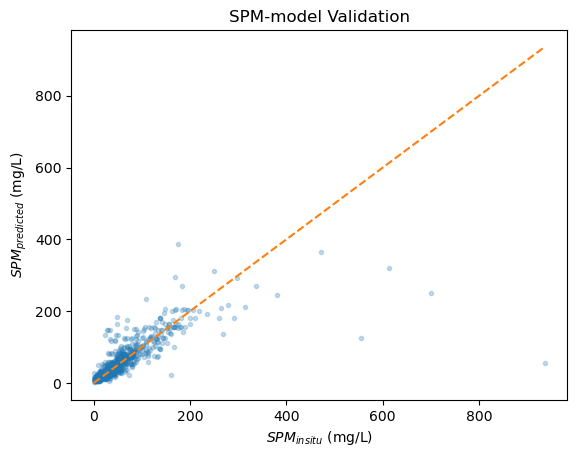

In [156]:
%load_ext autoreload
%autoreload 2

import functions_model as funcs_model
import matplotlib.pyplot as plt
from sklearn import metrics
import smogn

# filter data
df_data = df.copy().loc[~np.isnan(df.red_mean)]
df_data = df_data.loc[abs(df_data.match_td_days)<=3]
df_data = df_data.loc[(df_data.spm<=1000) & (df_data.spm>=0)]

# sample equally for wet and dry season
df_data['season'] = pd.to_datetime(df_data.dt_utc).dt.month.apply(lambda x: 'wet' if 6 <= x <= 11 else 'dry')
n_wet = df_data.loc[df_data.season=='wet'].shape[0]  
df_data = df_data.groupby('season', group_keys=False).apply(lambda x: x.sample(n_wet), include_groups=False)

# filter features
label = 'spm'
smpl_method = 'mean' # sampling method
#regex_expr = f'^(blue|red|green|nir|is_water|is_cloud|add_|{label})' # allow all starting with given str and target variable
regex_expr = f'_{smpl_method}$|^{label}$' # allow only ending with _mean and target variable
df_data = df_data.filter(regex=regex_expr)
df_data.columns = df_data.columns.str.replace(f'_{smpl_method}$', '', regex=True)

## Server-side model (GEE)
# apply train-test-split and create server-side regressor
df_train, df_test, df_predicted, ee_rf_model = funcs_model.construct_ee_model(
    df_data, label=label,
    downsample=False,
    n_estimators=100,
    q=10, 
    apply_smogn=True, 
    smogn_settings={
        'rel_thres': 0.90,
        'k': 10,
        'rel_xtrm_type': 'high',
        'samp_method': 'extreme',
        'rel_method': 'auto',
        }
    )

## Local model for quick testing (sklearn)
# apply train-test-split and create local regressor
# df_train, df_test, df_predicted, rf_model = funcs_model.construct_local_model(
#     df_data, label=label,
#     n_estimators=100,
#     q=10, 
#     apply_pca=False, n_components=5,
#     apply_smogn=True, 
#     smogn_settings={
#         'rel_thres': 0.90,
#         'k': 10,
#         'rel_xtrm_type': 'high',
#         'samp_method': 'extreme',
#         'rel_method': 'auto',
#         }
#     )

# Plot validation results
predictions = df_predicted[f'{label}_predicted']
test_labels = df_predicted[label]
errors = abs(predictions - test_labels)
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'mg/L.')
print('Accuracy:', round(accuracy, 2), '%.')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_labels, predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_labels, predictions))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(test_labels, predictions)))
mape = np.mean(np.abs((test_labels - predictions) / np.abs(test_labels)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

# plot the results
sorted_indices = np.argsort(test_labels)
test_labels_sorted = test_labels[sorted_indices]
predictions_sorted = predictions[sorted_indices]
plt.plot(test_labels_sorted, predictions_sorted, '.', label="data", alpha=0.25)
plt.plot(test_labels_sorted, test_labels_sorted, '--', label="1:1")
plt.xlabel('$SPM_{insitu}$ (mg/L)')
plt.ylabel('$SPM_{predicted}$ (mg/L)')
plt.title("SPM-model Validation")

## Export RF-Regressor model to GEE asset

In [157]:
asset_name = 'sosw_spm_rfregressor_sr_14052024'
folder_name = r'projects/ee-soswater/assets/classifiers'
asset_id = folder_name + '/' + asset_name
try:
    ee.data.createAsset({'type': 'Folder'}, folder_name)
    print(f'Folder "{folder_name}" created successfully.')
except Exception as e:
    print(f'Error creating folder: {e}')

task = ee.batch.Export.classifier.toAsset(
    classifier=ee_rf_model,
    description=asset_name,
    assetId=asset_id
)
task.start()

Error creating folder: Cannot overwrite asset 'projects/ee-soswater/assets/classifiers'.


In [158]:
check_tasks_status([task])

[2024-05-15 00:02:15] Task WPVHVKGJPCIHGGHBTS4XQ5N7(sosw_spm_rfregressor_sr_14052024): COMPLETED


['COMPLETED']